In [1]:
from pydlr import kernel, dlr
from triqs.gf import *
from h5 import HDFArchive
import numpy as np
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint

import matplotlib.pyplot as plt
plt.style.use('publish')

from dimer import *
from common import *

Starting serial run at: 2023-02-09 06:51:48.737920


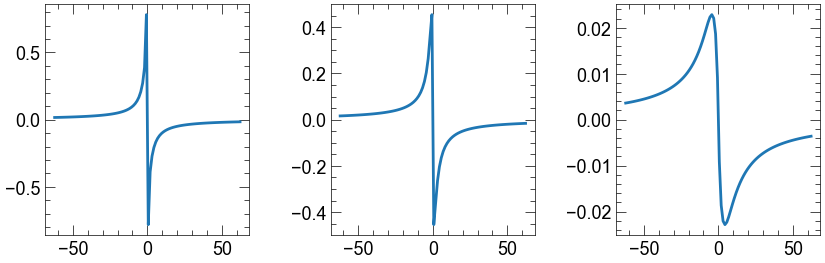

In [2]:
iwn = np.array([complex(x) for x in Sigma_iw_ref.mesh])
fig, ax = plt.subplots(1,3, figsize=(10, 3))
ax[0].plot(iwn.imag, G0_iw['up'].data[:,0,0].imag)
ax[1].plot(iwn.imag, G_iw_ref['up'].data[:,0,0].imag)
ax[2].plot(iwn.imag, Sigma_iw_ref['up'].data[:,0,0].imag)
plt.subplots_adjust(wspace=0.4)

In [3]:
class Symmetrizer:

    def __init__(self, nx, no):
        self.N = (no*(no-1))//2
        self.nx, self.no = nx, no
        self.diag_idxs = np.arange(self.no)
        self.triu_idxs = np.triu_indices(no, k=1)
        self.tril_idxs = np.tril_indices(no, k=-1)
    
    def get_x_d(self, g_xaa):
        x_d = g_xaa[:, self.diag_idxs, self.diag_idxs].flatten()
        return x_d

    def set_x_d(self, g_xaa, x_d):
        g_xaa[:, self.diag_idxs, self.diag_idxs] = x_d.reshape((self.nx, self.no))
        return g_xaa

    def get_x_u(self, g_xaa):
        x_u = g_xaa[:, self.triu_idxs[0], self.triu_idxs[1]].flatten()
        return x_u

    def set_x_u(self, g_xaa, x_u):
        g_xaa[:, self.triu_idxs[0], self.triu_idxs[1]] = x_u.reshape((self.nx, self.N))
        g_xaa[:, self.tril_idxs[0], self.tril_idxs[1]] = g_xaa[:, self.triu_idxs[0], self.triu_idxs[1]].conj()
        #g_xaa += np.transpose(g_xaa, axes=(0,2,1)).conj()
        return g_xaa

    def get_diag_indices(self): return self.diag_idxs
    def get_triu_indices(self): return self.triu_idxs

In [71]:
def constrained_lstsq_dlr_from_tau(d, 
                                   tau_i,
                                   iw_i,
                                   g_iaa,     # G data
                                   g0_iaa,    # G0 data
                                   beta,
                                   sigma_moments,
                                   ftol=1e-9, 
                                   symmetrizer=None):
    
    
    
    
    
    nx = len(d)
    ni, no, _ = g_iaa.shape
    shape_xaa = (nx, no, no)
    N = (no*(no-1))//2

    dtype = complex
    nX = nx * (no + 2*N)
    
    # fold and unfold complex numbers
    
    def merge_re_im(x):
        x_d, x_u = x[:nx*no], x[nx*no:]
        re, im = np.split(x_u, 2)
        x_u = re + 1.j * im
        return x_d, x_u

    def split_re_im(x_d, x_u):
        return np.concatenate((
            np.array(x_d.real, dtype=float),
            np.array(x_u.real, dtype=float),
            np.array(x_u.imag, dtype=float)))
                                   
    # Greens function <-> vector conversion

    sym = symmetrizer if symmetrizer is not None else Symmetrizer(nx, no)
    
    def g_from_x(x):
        x_d, x_u = merge_re_im(x)
        g_xaa = np.zeros((nx, no, no), dtype=dtype)
        sym.set_x_u(g_xaa, x_u)
        sym.set_x_d(g_xaa, x_d)
        return g_xaa
                        
    def x_from_g(g_xaa):
        x_d = sym.get_x_d(g_xaa)
        x_u = sym.get_x_u(g_xaa)
        x = split_re_im(x_d, x_u)
        return x
    
    
    # constraint
    
    sig_infty, sigma_1 = sigma_moments[0], sigma_moments[1]
        
    def mat_vec(mat):
        v_d = sym.get_x_d(mat[None, ...]).real
        v_u = sym.get_x_u(mat[None, ...])
        v = split_re_im(v_d, v_u)
        return v
        
    def constraint_func(x):
        sig = g_from_x(x)
        mat = -sig.sum(axis=0)
        vec = mat_vec(mat)
        return vec
    
    bound = mat_vec(sigma_1)
    
    constraints = (NonlinearConstraint(constraint_func,
                                           bound, bound))


    # target functions
    
    def dyson_difference(x_sig, x, x0):
        # G - G0 - G0*Σ*G = 0
        
        g_xaa = g_from_x(x)
        g0_xaa = g_from_x(x0)
        sig_xaa = g_from_x(x_sig)
        
        # evaulate G, G0, Sigma on DLR nodes
        g_waa = d.eval_dlr_freq(g_xaa, iw_i, beta)
        g0_waa = d.eval_dlr_freq(g0_xaa, iw_i, beta)
        sig_waa = d.eval_dlr_freq(sig_xaa, iw_i, beta) + sig_infty
        
        err_waa = g_waa - g0_waa - g0_waa[:,...]@sig_waa[:,...]@g_waa[:,...]
        
        return err_waa.flatten()
        
    def target_function(x_sig, x, x0):
        y = dyson_difference(x_sig, x, x0)
        # replace with the L2(τ) norm
        return np.linalg.norm(y) 
    
    # initial dlr fit to G and G0
    g_init_xaa = d.lstsq_dlr_from_tau(tau_i, g_iaa, beta)
    g0_init_xaa = d.lstsq_dlr_from_tau(tau_i, g0_iaa, beta)
    

    # convert G and G0 to iω using DLR coeffs. 
    g_waa = d.matsubara_from_dlr(g_init_xaa, beta)
    g0_waa = d.matsubara_from_dlr(g0_init_xaa, beta)
    
    # obtain initial sigma
    # Σdlr = Σ(iω)-Σoo
    sig_init_xaa = (np.linalg.inv(g_waa)-np.linalg.inv(g0_waa)) - sig_infty
    # we can also initialize to just the high-frequency part?

    x_init  = x_from_g(g_init_xaa)         # DLR coeffs of G(tau)
    x0_init = x_from_g(g0_init_xaa)        # DLR coeffs of G0(tau
    sig_init = x_from_g(sig_init_xaa)      # DLR coeffs of Σ(iwn)-Σoo.

    
    sol = minimize(target_function, sig_init,
        args=(x_init, x0_init),
        method='SLSQP', 
        constraints=constraints,
        options=dict(ftol=ftol, maxiter=1000, disp=True),
        )
    print(sol.success, sol.message)

    return g_from_x(sol.x), sol

In [72]:
def fit_dlr(d, iw, G_tau, G0_tau, Sigma_moments, ftol=1e-8):
    
    tau = np.array([float(x) for x in G_tau.mesh])
    
    beta = G_tau.mesh.beta
    
    sig_xaa = {}
    for block, gf in G_tau:
        
        sig_xaa[block], sol = constrained_lstsq_dlr_from_tau(d, tau, iw,
                                                         G_tau[block].data, 
                                                         G0_tau[block].data,
                                                         beta,
                                                         Sigma_moments[block],
                                                         ftol=ftol,
                                                        )
    return sig_xaa

In [73]:
sigma_moments = sigma_high_frequency_moments(dm, hdiag, gf_struct, h_int)

In [74]:
d = dlr(lamb=30)

In [75]:
G0_tau = make_gf_from_fourier(G0_iw)

In [76]:
tau_i = np.array([x.real for x in G0_tau.mesh])
iw_i  = np.array([complex(x) for x in Sigma_iw_ref.mesh])

In [79]:
sig_xaa, sol = constrained_lstsq_dlr_from_tau(d, 
                                   tau_i, 
                                   iw_i,
                                   G_tau_ref['up'].data,
                                   G0_tau['up'].data,
                                   beta,
                                   sigma_moments['up'],
                                   ftol=1e-9, 
                                   symmetrizer=None)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.607743491095452e-06
            Iterations: 90
            Function evaluations: 9570
            Gradient evaluations: 90
True Optimization terminated successfully


In [80]:
Sigma_iw_fit = Sigma_iw_ref.copy()
Sigma_iw_fit['up'].data[:] = d.eval_dlr_freq(sig_xaa, iw_i, beta) +sigma_moments['up'][0]

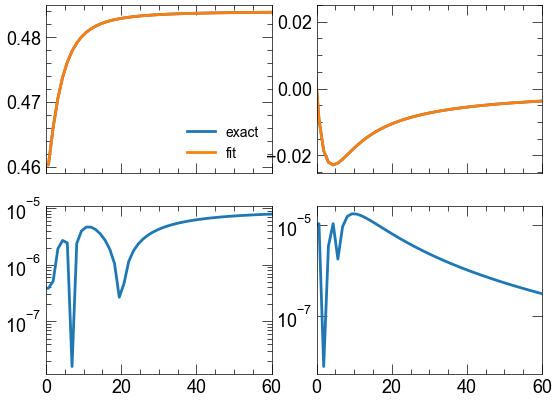

In [81]:
fig, ax = plt.subplots(2,2,sharex=True)
ax[0,0].plot(iwn.imag, Sigma_iw_ref['up'].data[:,0,0].real, label='exact')
ax[0,0].plot(iwn.imag, Sigma_iw_fit['up'].data[:,0,0].real, label='fit')
ax[1,0].semilogy(iwn.imag, np.abs(Sigma_iw_ref['up'].data[:,0,0].real-Sigma_iw_fit['up'].data[:,0,0].real))
ax[0,0].legend()
ax[0,1].plot(iwn.imag, Sigma_iw_ref['up'].data[:,0,0].imag, label='exact')
ax[0,1].plot(iwn.imag, Sigma_iw_fit['up'].data[:,0,0].imag, label='fit')
ax[1,1].semilogy(iwn.imag, np.abs(Sigma_iw_ref['up'].data[:,0,0].imag-Sigma_iw_fit['up'].data[:,0,0].imag))
ax[0,0].legend()
ax[0,0].set_xlim(0,60)
plt.show()

In [82]:
tol = 1e-4
G_tau_qmc= G_tau_ref.copy()
G_tau_qmc['up'].data[:] += np.random.normal(scale=tol, size=G_tau_qmc['up'].data.shape)
d = dlr(lamb=30,eps=1e-6)

In [86]:
sig_xaa, sol = constrained_lstsq_dlr_from_tau(d, 
                                   tau_i,
                                   iw_i,
                                   G_tau_qmc['up'].data,
                                   G0_tau['up'].data,
                                   beta,
                                   sigma_moments['up'],
                                   ftol=1e-12, 
                                   symmetrizer=None)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.282660378904315e-05
            Iterations: 164
            Function evaluations: 8759
            Gradient evaluations: 164
True Optimization terminated successfully


In [87]:
Sigma_iw_fit = Sigma_iw_ref.copy()
Sigma_iw_fit['up'].data[:] = d.eval_dlr_freq(sig_xaa, iw_i, beta)+sigma_moments['up'][0]

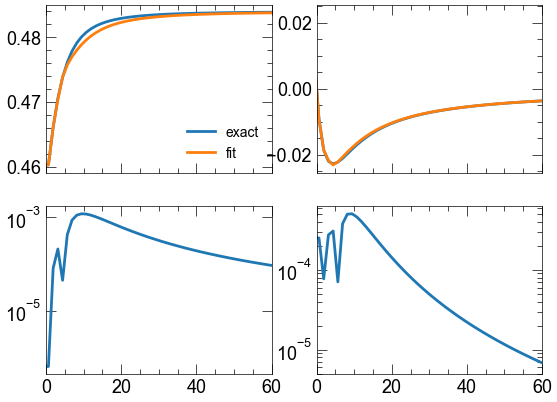

In [88]:
fig, ax = plt.subplots(2,2,sharex=True)
ax[0,0].plot(iwn.imag, Sigma_iw_ref['up'].data[:,0,0].real, label='exact')
ax[0,0].plot(iwn.imag, Sigma_iw_fit['up'].data[:,0,0].real, label='fit')
ax[1,0].semilogy(iwn.imag, np.abs(Sigma_iw_ref['up'].data[:,0,0].real-Sigma_iw_fit['up'].data[:,0,0].real))
ax[0,0].legend()
ax[0,1].plot(iwn.imag, Sigma_iw_ref['up'].data[:,0,0].imag, label='exact')
ax[0,1].plot(iwn.imag, Sigma_iw_fit['up'].data[:,0,0].imag, label='fit')
ax[1,1].semilogy(iwn.imag, np.abs(Sigma_iw_ref['up'].data[:,0,0].imag-Sigma_iw_fit['up'].data[:,0,0].imag))
ax[0,0].legend()
ax[0,0].set_xlim(0,60)
plt.show()

In [89]:
tol = 1e-4
G_tau_qmc= G_tau_ref.copy()
G_tau_qmc['up'].data[:] += np.random.normal(scale=tol, size=G_tau_qmc['up'].data.shape)
d = dlr(lamb=30,eps=1e-6)
sig_xaa = fit_dlr(d, iw_i, G_tau_qmc, G0_tau, sigma_moments)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00010044494899484628
            Iterations: 116
            Function evaluations: 6200
            Gradient evaluations: 116
True Optimization terminated successfully
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.725505376719073e-05
            Iterations: 82
            Function evaluations: 4427
            Gradient evaluations: 82
True Optimization terminated successfully


In [90]:
Sigma_iw_fit = Sigma_iw_ref.copy()
for block, sig in Sigma_iw_fit: Sigma_iw_fit[block].data[:] = d.eval_dlr_freq(sig_xaa[block], iw_i, beta)+sigma_moments[block][0]

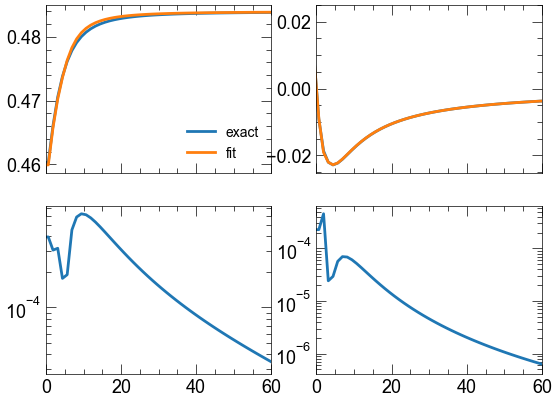

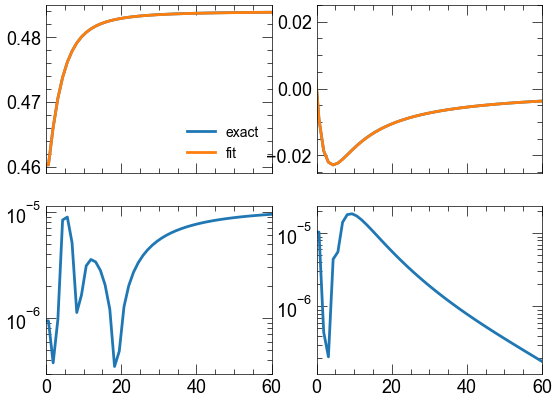

In [91]:
for block, sig in Sigma_iw_fit:
    fig, ax = plt.subplots(2,2,sharex=True)
    ax[0,0].plot(iwn.imag, Sigma_iw_ref[block].data[:,0,0].real, label='exact')
    ax[0,0].plot(iwn.imag, Sigma_iw_fit[block].data[:,0,0].real, label='fit')
    ax[1,0].semilogy(iwn.imag, np.abs(Sigma_iw_ref[block].data[:,0,0].real-Sigma_iw_fit[block].data[:,0,0].real))
    ax[0,0].legend()
    ax[0,1].plot(iwn.imag, Sigma_iw_ref[block].data[:,0,0].imag, label='exact')
    ax[0,1].plot(iwn.imag, Sigma_iw_fit[block].data[:,0,0].imag, label='fit')
    ax[1,1].semilogy(iwn.imag, np.abs(Sigma_iw_ref[block].data[:,0,0].imag-Sigma_iw_fit[block].data[:,0,0].imag))
    ax[0,0].legend()
    ax[0,0].set_xlim(0,60)
plt.show()